# Portfolios Example

In [1]:
%matplotlib notebook
import numpy as np
import load_factors as lf
import factors
import pickle
from factor_portfolio import Factor_Portfolio
from factor_multi_portfolio import Factor_Multi_Portfolio
from multiplicative_weigths import Multiplicative_Weights
from pattern_matching import Pattern_Matching
from algorithm_result import AlgorithmResultsList
from filter import Filter
import warnings
import time
warnings.filterwarnings('ignore')

Pre-process (Run only once)

In [ ]:
assets_list=lf.load_assets(['price_to_book','earnings_to_price','brand_rank'], '../data/')
prices=lf.create_factor_df(assets_list,'close',isForwardFill=False)
returns=factors.prices_to_returns(prices)
ibx_filter=Filter('../data/filter/IBX.csv')
pickle.dump(ibx_filter, open('../dump/ibx_filter.p', 'wb'))
pickle.dump(assets_list, open('../dump/assets_list.p', 'wb'))
pickle.dump(prices, open('../dump/prices.p', 'wb'))
pickle.dump(returns, open('../dump/returns.p', 'wb'))

Load objects (Run otherwise)

In [2]:
#load objects
assets_list=pickle.load(open('../dump/assets_list.p','rb'))
prices=pickle.load(open('../dump/prices.p', 'rb'))
returns=pickle.load(open('../dump/returns.p', 'rb'))
ibx_filter=pickle.load(open('../dump/ibx_filter.p', 'rb'))

Filter PN Assets only

In [3]:
#get only PN assets
assets_list=lf.get_only_PN(assets_list)
assets_list_name=[]
for asset in assets_list:
    assets_list_name.append(asset.name)
prices=prices[assets_list_name]
returns=returns[assets_list_name]

### MWU algorithm

In [4]:
start = time.time()
algorithm = Multiplicative_Weights(eta=0.1)
algorithm.rebalance_window=1
algorithm.rebalance_period='monthly'
algorithm.cost=.004
result_mwu = algorithm.run(returns,start_date='01/01/2006')
end = time.time()
print('MWU Elapsed time: ', (end-start), ' segundos')
print(result_mwu.summary())

MWU Elapsed time:  2.021373987197876  segundos
Summary:
        Yrly ROA: 0.30
        Yrly Sharpe Ratio: 1.26
        Annualized return: 19.76%
        Annualized volatility: 14.25%
        Longest drawdown: 306 days
        Net Return: 686.24%
        Winning days: 55.8%
        Start Date: 01/2006
        End Date: 08/2017
        


<IPython.core.display.Javascript object>


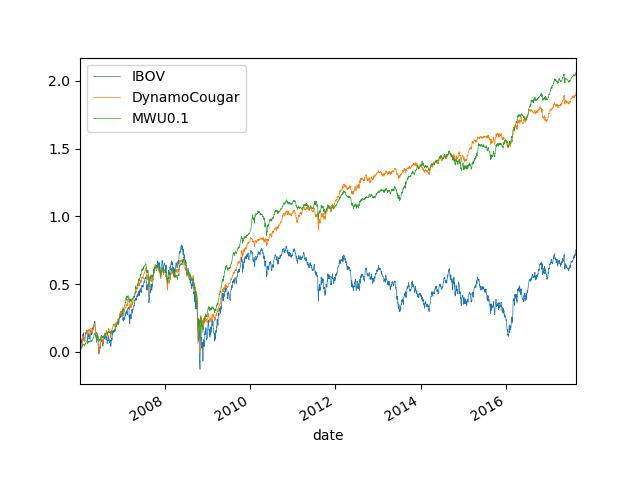

<IPython.core.display.Javascript object>


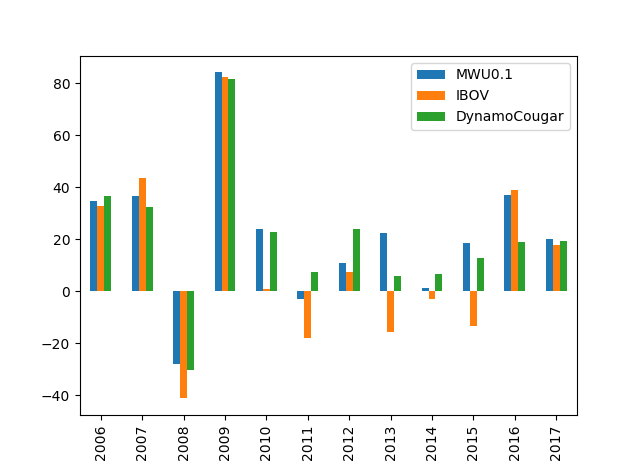

In [5]:
result_mwu.add_benchmark('../data/benchmark/IBOV.csv')
result_mwu.add_benchmark('../data/benchmark/DynamoCougar.csv')
result_mwu.plot()
result_mwu.plot_yrly_result()

### Momentum algorithm

In [6]:
start = time.time()
#Create
algorithm = Factor_Portfolio([], 'momentum', 15)
#Set parameters
algorithm.factor_df=factors.momentum_sma(prices, 21, 252)
algorithm.add_filter(ibx_filter)
algorithm.portfolio_size=15
algorithm.rebalance_window=1
algorithm.rebalance_period='monthly'
algorithm.cost=.004
#Run
result_momentum = algorithm.run(returns,start_date='01/01/2006')
end = time.time()
print('Factor Portfolio run time: ', (end-start), ' segundos')
print(result_momentum.summary())

Factor Portfolio run time:  1.8098061084747314  segundos
Summary:
        Yrly ROA: 0.19
        Yrly Sharpe Ratio: 0.68
        Annualized return: 16.95%
        Annualized volatility: 22.94%
        Longest drawdown: 740 days
        Net Return: 499.57%
        Winning days: 54.1%
        Start Date: 01/2006
        End Date: 08/2017
        


### Low volatility algorithm

In [7]:
start = time.time()
#Create
algorithm = Factor_Portfolio([], 'vol', 15)
#Set parameters
algorithm.factor_df=factors.vol(returns, 252)
algorithm.reverse_order=True
algorithm.add_filter(ibx_filter)
algorithm.portfolio_size=15
algorithm.rebalance_window=1
algorithm.rebalance_period='monthly'
algorithm.cost=.004
#Run
result_vol = algorithm.run(returns,start_date='01/01/2006')
end = time.time()
print('Factor Portfolio run time: ', (end-start), ' segundos')
print(result_vol.summary())

Factor Portfolio run time:  6.134615898132324  segundos
Summary:
        Yrly ROA: 0.24
        Yrly Sharpe Ratio: 0.84
        Annualized return: 16.58%
        Annualized volatility: 18.30%
        Longest drawdown: 533 days
        Net Return: 478.13%
        Winning days: 54.0%
        Start Date: 01/2006
        End Date: 08/2017
        


### Pattern Matching algorithm

In [8]:
start = time.time()
algorithm = Pattern_Matching(window_size=22,c_threshold=0.6)
algorithm.rebalance_window=1
algorithm.rebalance_period='monthly'
algorithm.cost=.004
result_pm = algorithm.run(returns,start_date='01/01/2006')
end = time.time()
print('Pattern Matching Elapsed time: ', (end-start), ' segundos')
print(result_pm.summary())

Pattern Matching Elapsed time:  36.028806924819946  segundos
Summary:
        Yrly ROA: 0.27
        Yrly Sharpe Ratio: 1.26
        Annualized return: 16.37%
        Annualized volatility: 12.01%
        Longest drawdown: 451 days
        Net Return: 466.19%
        Winning days: 56.6%
        Start Date: 01/2006
        End Date: 08/2017
        


### Join results

In [9]:
res_list=[result_momentum,result_vol,result_mwu,result_pm]

<IPython.core.display.Javascript object>


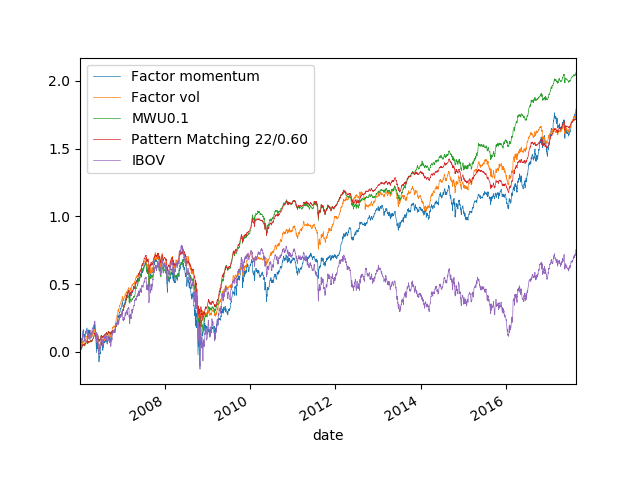

In [10]:
results = AlgorithmResultsList(res_list)
results.add_benchmark('../data/benchmark/IBOV.csv')
results.plot()

<IPython.core.display.Javascript object>


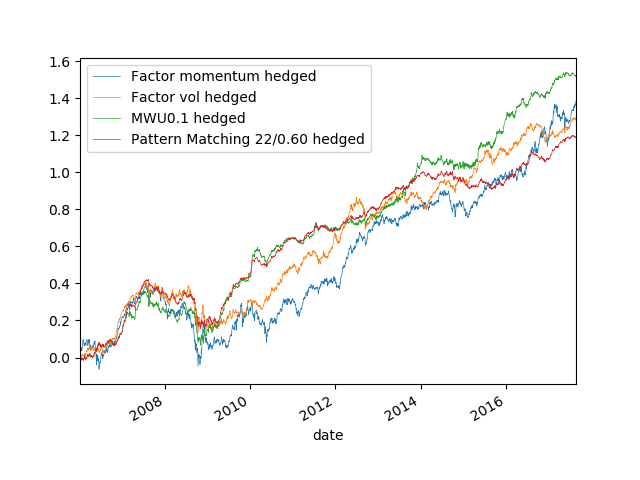

In [14]:
hedged_res_list=[]
for result in res_list:
    temp=result.get_hedged_result('../data/benchmark/IBOV.csv',0.5)
    hedged_res_list.append(temp)
results = AlgorithmResultsList(hedged_res_list)
results.plot()